In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns


## Beolvasása és hozamszámítás

In [216]:
data = pd.read_excel('data.xlsx', sheet_name='Napi',skiprows=1)
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data.sort_index(ascending=False, inplace=True)

rf = 0.042045566   #benne van a fileban, most csak kivettem a jelenlegi értékét
data = data.loc['2023-01-03':]   #itt ezzel lehet kiserletezni 22 elejetol 25 feb vegeig van adat

# napi log hozamok
daily_returns = np.log(data / data.shift(-1))
T = len(data)
# évesített várható hozam
mean_returns = daily_returns.mean() * 250  
#piaci portfolio
market_ret = mean_returns['SP500']*0.3+mean_returns['MSCI World']*0.3+mean_returns['Global agg bond']*0.4
print(F'Piaci hozam: {100 * market_ret:.2f} %')
print(f'Kockázatmentes hozam: {100 * rf:.2f} %' )
# levonjuk a risk free ratet
mean_returns = mean_returns - rf 
# évesített kovariancia mátrix
cov_matrix = daily_returns.cov() * 250
corr_matrix = daily_returns.corr()
num_assets = len(mean_returns)
std = np.sqrt(np.diag(np.array(cov_matrix)))
std = pd.Series(index=mean_returns.index, data=std)
colors = sns.color_palette("tab20", num_assets)  

Piaci hozam: 12.46 %
Kockázatmentes hozam: 4.20 %


In [217]:
pd.options.display.float_format = '{:.2f}%'.format

asset_summarum = pd.DataFrame(index = mean_returns.index, columns = ['Várható érték', 'Szórás'])
asset_summarum['Várható érték'] = mean_returns   
asset_summarum['Szórás'] = std
asset_summarum*100


,Várható érték,Szórás
SP500,16.30%,12.86%
MSCI World,13.41%,11.26%
MSCI MXEA,5.60%,12.38%
MSCI EM,1.86%,13.30%
Global agg bond,-1.64%,6.09%
US agg bond,-0.05%,6.29%
US corp HY,5.98%,3.92%
Gold,16.19%,14.20%
DAX,16.61%,16.16%
MSFT,19.18%,22.84%


In [218]:
pd.options.display.float_format = '{:.2f}'.format
corr_matrix

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM
SP500,1.00,0.96,0.39,0.29,0.13,0.14,0.55,0.12,0.44,0.66,0.49,0.09,0.35,0.21
MSCI World,0.96,1.00,0.63,0.43,0.26,0.19,0.66,0.17,0.63,0.59,0.48,0.07,0.49,0.23
MSCI MXEA,0.39,0.63,1.00,0.62,0.47,0.25,0.64,0.21,0.83,0.16,0.20,0.03,0.64,0.15
MSCI EM,0.29,0.43,0.62,1.00,0.23,0.08,0.40,0.20,0.42,0.19,0.11,0.01,0.35,0.09
Global agg bond,0.13,0.26,0.47,0.23,1.00,0.86,0.59,0.38,0.42,0.04,-0.11,0.13,0.26,-0.07
US agg bond,0.14,0.19,0.25,0.08,0.86,1.00,0.54,0.37,0.23,0.04,-0.12,0.15,0.11,-0.08
US corp HY,0.55,0.66,0.64,0.40,0.59,0.54,1.00,0.16,0.59,0.29,0.25,0.10,0.42,0.16
Gold,0.12,0.17,0.21,0.20,0.38,0.37,0.16,1.00,0.19,0.08,-0.06,0.03,0.11,0.08
DAX,0.44,0.63,0.83,0.42,0.42,0.23,0.59,0.19,1.00,0.22,0.21,0.04,0.79,0.13
MSFT,0.66,0.59,0.16,0.19,0.04,0.04,0.29,0.08,0.22,1.00,0.12,-0.07,0.18,-0.10


# Függvények

In [219]:
# portfólió varinciája
def portfolio_variance(weights):
    return weights.T @ cov_matrix @ weights

# portfólió hozama
def portfolio_return(weights):
    return np.dot(weights, mean_returns)

# max portfoliohoz
def portfolio_return_neg(weights):
    return -np.dot(weights, mean_returns)

# hasznossági függvény negativan adom meg hogy minimalizalni kelljen 
def utility_function(weights, gamma):
    return -portfolio_return(weights) + gamma/2 *portfolio_variance(weights)


def adjusted_mu(epsilon):
    return np.sqrt(np.diag(cov_matrix) * epsilon / T)

def portfolio_epsilon(epsilon):
    return epsilon * (T-1)*num_assets / ((T-num_assets) * T)

#hasznossági függvény amikor minden eszközre bizonytalanságot adsz meg 
def utility_function_uncertainity_1(weights, gamma, epsilon:np.array):
    return - np.dot(weights, mean_returns-adjusted_mu(epsilon)) + gamma/2 *portfolio_variance(weights)
     
#hasznossági függvény amikor a portfólióra adsz meg bizonytalanságot
def utility_function_uncertainity_2(weights, gamma, epsilon:float):
    return - portfolio_return(weights) + gamma/2 *portfolio_variance(weights) + np.sqrt((portfolio_epsilon(epsilon)*weights).T @ cov_matrix @ weights)

# Megszorítások 

In [220]:
#csak a portólió súlyok
def constraints_weight():
    return [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]

#Megszórítások: Eltalálja az elvárt hozamot és 1re összegződjenek a súlyok
def constraints(target_return):
    return [
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights) - target_return},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]

def constraints_uncer(target_return):
    return [
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights) - target_return},
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    ]



# korlátok 
bounds_short_allowed = tuple((-1, 1) for _ in range(num_assets))
bounds_without_shortselling = tuple((0, 1) for _ in range(num_assets))
# kezdőpont

initial_guess = np.array([1/num_assets]*num_assets)


# Most jöhet a portfólióalkotás 
1. Adjunk 0.1 bizonytalanságot a modellnek és a gamman iteralunk 
2. Adjuk meg a bizonytalanságot asset-by-asset és az egyik eszköz bizonytalanságát növeljük és nézzük meg, hogyan változik a portfólióban betöltött szerepe. 
3. Rögzített gammánál változtassuk a bizonytalanságot 
4. Határportfóló görbék változása 

# Rögzített bizonytalanság mellett gamma változik

### Shortselling engedélyezett

In [221]:
gamma = [0,2,4,6,8] + [10*x for x in range(1,11)]
epsilon = 200   #ezen az erteken lehet valtoztatni

optimal_portfolios = pd.DataFrame(index=gamma, columns = list(mean_returns.index) + ['return', 'std'])

for g in gamma:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_uncertainity_2(w, g, epsilon), initial_guess, 
                      method='SLSQP', bounds=bounds_short_allowed, 
                      constraints=constraints_weight())
    optimal_portfolios.loc[g] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,1.00,-1.00,-0.57,-0.14,-1.00,-0.01,1.00,0.95,1.00,0.01,0.53,-0.37,-0.12,-0.27,0.55,0.21
2,0.81,-1.00,-0.19,-0.03,-1.00,0.46,1.00,0.49,0.57,0.01,0.27,-0.17,-0.08,-0.13,0.31,0.11
4,0.76,-1.00,-0.08,-0.01,-0.85,0.45,1.00,0.38,0.41,0.01,0.20,-0.12,-0.06,-0.09,0.24,0.09
6,0.74,-1.00,-0.03,-0.00,-0.65,0.34,1.00,0.31,0.33,0.01,0.17,-0.09,-0.05,-0.07,0.21,0.07
8,0.73,-1.00,-0.01,0.00,-0.54,0.28,1.00,0.28,0.28,0.01,0.15,-0.08,-0.04,-0.06,0.19,0.07


Text(0, 0.5, 'Portfólió súly')

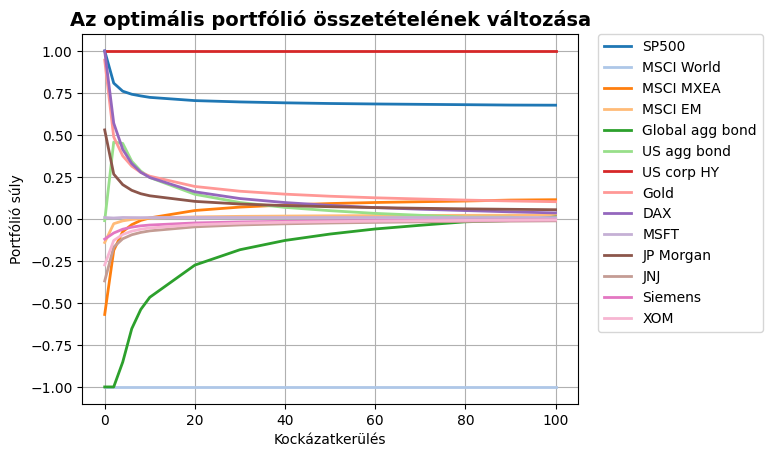

In [222]:
optimal_portfolios[mean_returns.index].plot(color = colors, linewidth = 2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid()

plt.title("Az optimális portfólió összetételének változása", fontsize = 14, fontweight="bold")
plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súly")


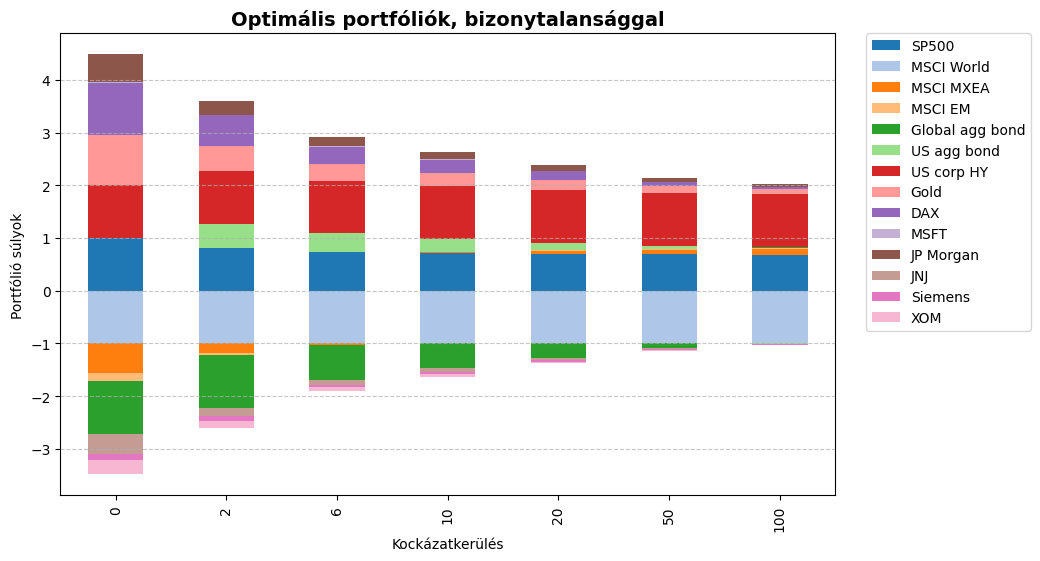

In [223]:

gamma_values = [0, 2, 6, 10, 20, 50, 100]
selected_portfolios = optimal_portfolios.loc[gamma_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked = True, color = colors)

plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók, bizonytalansággal", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Shortselling nélkül

In [224]:
#epsilon = np.array([200]*num_assets)
epsilon = 50
gamma = [0,2,4,6,8] + [10*x for x in range(1,11)]
optimal_portfolios = pd.DataFrame(index=gamma, columns = list(mean_returns.index) + ['return', 'std'])

for g in gamma:
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_uncertainity_2(w, g, epsilon), initial_guess, 
                      method='SLSQP', bounds=bounds_without_shortselling, 
                      constraints=constraints_weight())
    optimal_portfolios.loc[g] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.11,0.13,0.36,0.00,0.00,0.00,0.21,0.11
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.14,0.13,0.33,0.00,0.00,0.00,0.20,0.11
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.15,0.12,0.31,0.00,0.00,0.00,0.20,0.11
6,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.32,0.09,0.09,0.23,0.00,0.00,0.00,0.16,0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.27,0.05,0.07,0.19,0.00,0.00,0.00,0.14,0.07


Text(0, 0.5, 'Portfólió súly')

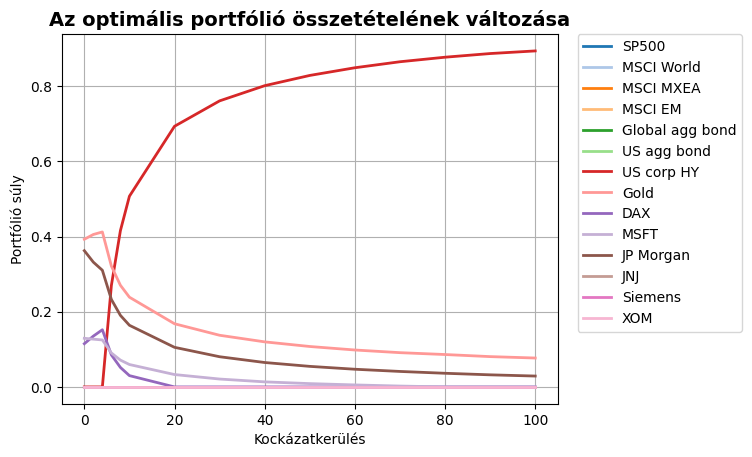

In [225]:
optimal_portfolios[mean_returns.index].plot(color = colors, linewidth = 2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid()

plt.title("Az optimális portfólió összetételének változása", fontsize = 14, fontweight="bold")
plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súly")

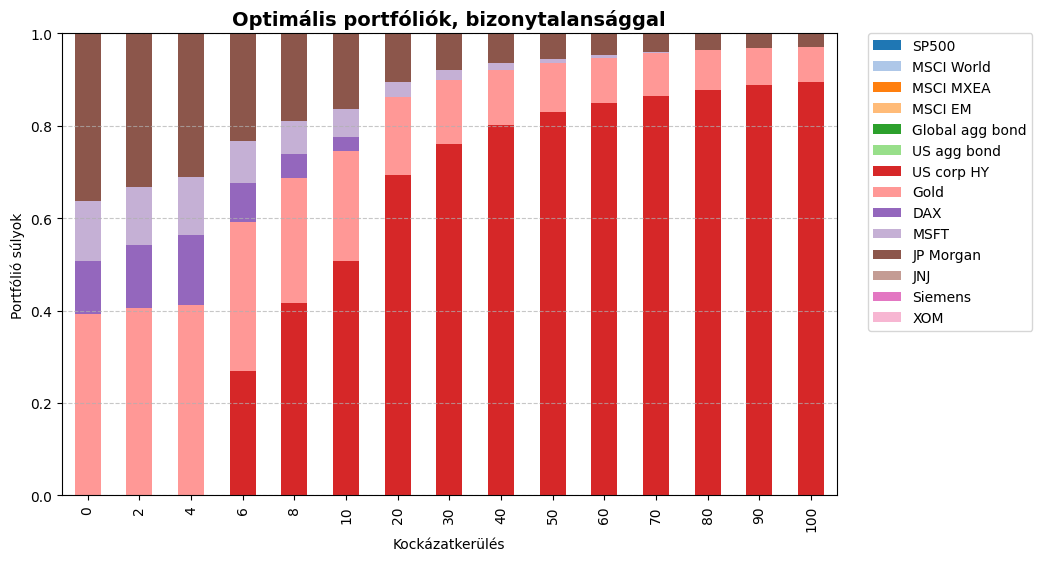

In [226]:
gamma_values = gamma
selected_portfolios = optimal_portfolios.loc[gamma_values, mean_returns.index]


selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked = True, color = colors)

plt.xlabel("Kockázatkerülés")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók, bizonytalansággal", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Most az epsilont engedjük iterálni gammat rögzítem 5-nél

### Short selling engedélyezett

In [227]:
epsilon = [10*x for x in range(31)]
gamma = 5  #ide mas gamma is mehetne 

optimal_portfolios = pd.DataFrame(index=epsilon, columns = list(mean_returns.index) + ['return', 'std'])

for e in epsilon:
    eps = np.array([e]*num_assets)
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_uncertainity_2(w, gamma, eps), initial_guess, 
                      method='SLSQP', bounds=bounds_short_allowed, 
                      constraints=constraints_weight())
    optimal_portfolios.loc[e] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios.head()

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,1.00,-0.09,-0.90,-0.41,-1.00,-0.34,1.00,1.00,1.00,0.04,1.00,-0.81,0.04,-0.53,0.86,0.37
10,1.00,-0.59,-0.72,-0.28,-1.00,-0.19,1.00,1.00,1.00,0.03,0.80,-0.60,-0.04,-0.41,0.71,0.29
20,1.00,-0.74,-0.67,-0.24,-1.00,-0.15,1.00,1.00,1.00,0.03,0.72,-0.52,-0.06,-0.37,0.66,0.26
30,1.00,-0.84,-0.63,-0.21,-1.00,-0.11,1.00,1.00,1.00,0.02,0.66,-0.47,-0.08,-0.34,0.62,0.25
40,1.00,-0.92,-0.60,-0.18,-1.00,-0.09,1.00,1.00,1.00,0.02,0.61,-0.43,-0.10,-0.31,0.60,0.23


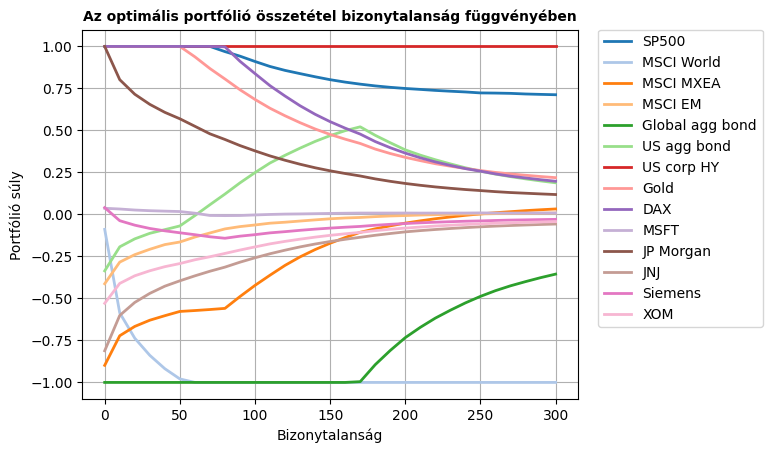

In [228]:
num_assets = len(mean_returns.index)

optimal_portfolios[mean_returns.index].plot(color=colors, linewidth=2)

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0, fontsize=10)
plt.grid()
plt.title("Az optimális portfólió összetétel bizonytalanság függvényében",fontsize = 10, fontweight="bold")
plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súly")

plt.show()


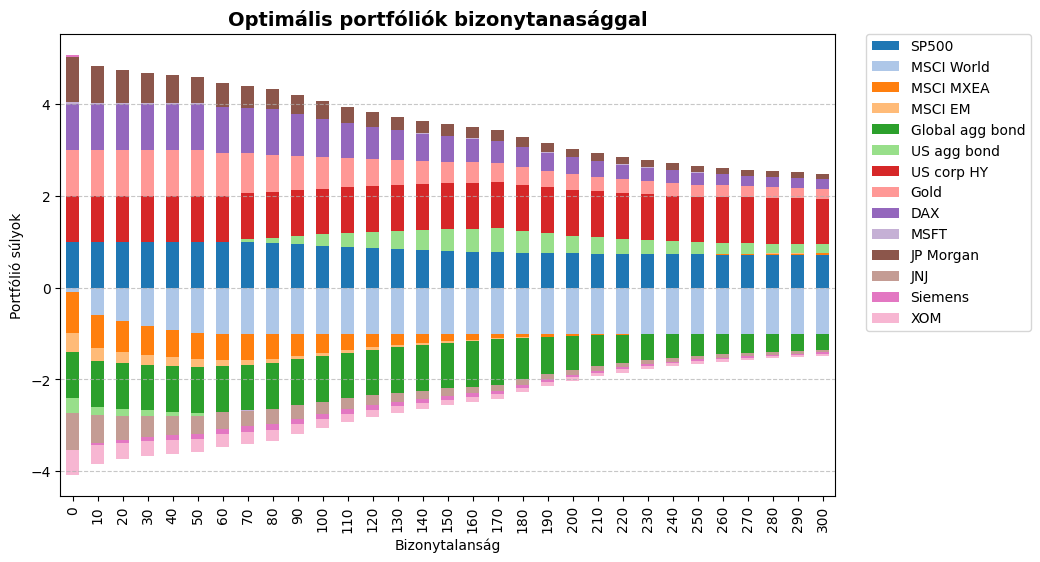

In [229]:
epsilon_values = epsilon
selected_portfolios = optimal_portfolios.loc[epsilon_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók bizonytanasággal   ", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


### Shortselling nélkül

In [230]:
epsilon = [25*x for x in range(21)]
gamma = 5  #ide mas gamma is mehetne 

optimal_portfolios = pd.DataFrame(index=epsilon, columns = list(mean_returns.index) + ['return', 'std'])

for e in epsilon:
    eps = np.array([e]*num_assets)
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_uncertainity_1(w, gamma, eps), initial_guess, 
                      method='SLSQP', bounds=bounds_without_shortselling, 
                      constraints=constraints_weight())
    optimal_portfolios.loc[e] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.13,0.55,0.00,0.04,0.00,0.23,0.13
25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37,0.02,0.09,0.52,0.00,0.00,0.00,0.22,0.13
50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.04,0.07,0.50,0.00,0.00,0.00,0.22,0.13
75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.05,0.05,0.49,0.00,0.00,0.00,0.22,0.12
100,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.03,0.00,0.45,0.00,0.00,0.00,0.21,0.12
125,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.02,0.00,0.43,0.00,0.00,0.00,0.21,0.12
150,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.01,0.00,0.41,0.00,0.00,0.00,0.21,0.12
175,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.39,0.00,0.00,0.00,0.20,0.12
200,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.37,0.00,0.00,0.00,0.20,0.11
225,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.35,0.00,0.00,0.00,0.20,0.11


Text(0, 0.5, 'Portfólió súly')

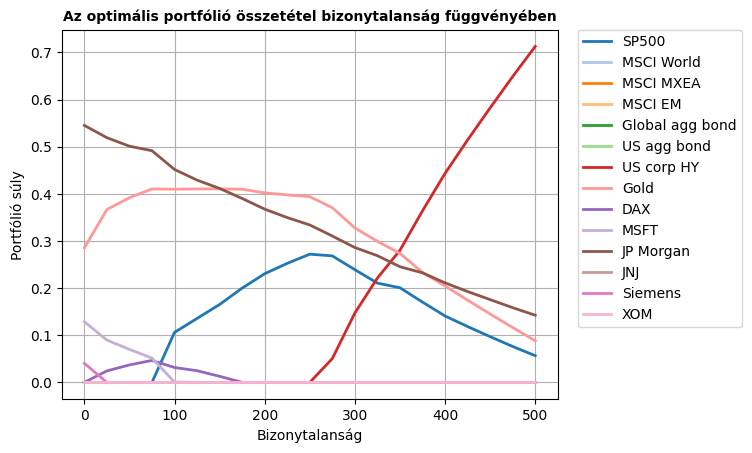

In [231]:
optimal_portfolios[mean_returns.index].plot(color = colors, linewidth = 2)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid()

plt.title("Az optimális portfólió összetétel bizonytalanság függvényében", fontsize = 10, fontweight="bold")
plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súly")

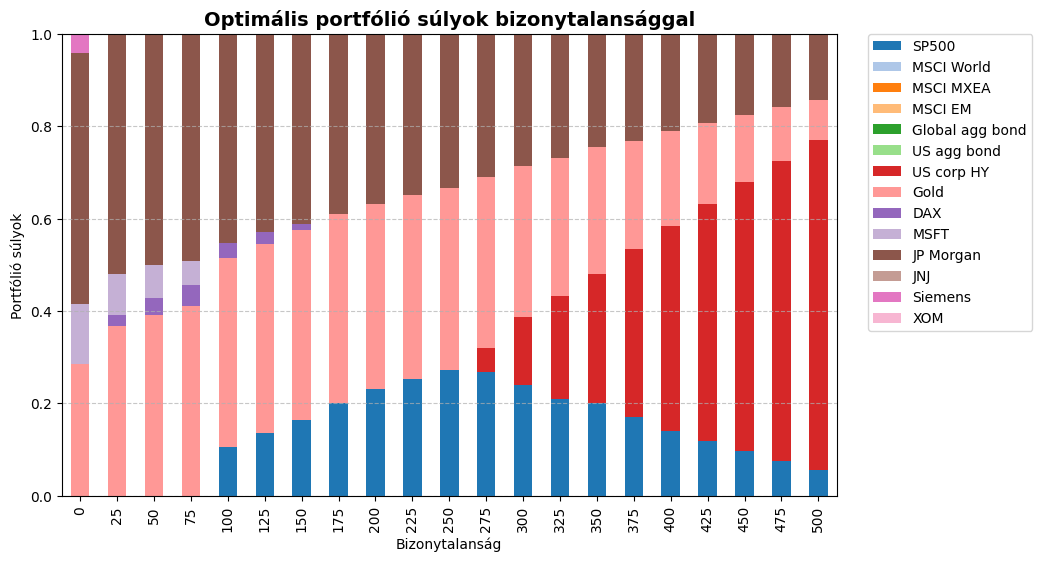

In [232]:
epsilon_values = epsilon
selected_portfolios = optimal_portfolios.loc[epsilon_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfólió súlyok bizonytalansággal", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Az arany bizonytalánságát növeljük 

### Short nélkül

In [233]:
epsilon = [5*x for x in range(15)]
gamma = 5  #ide mas gamma is mehetne 
optimal_portfolios = pd.DataFrame(index=epsilon, columns = list(mean_returns.index) + ['return', 'std'])

for e in epsilon:
    eps = np.array([0]*num_assets)
    eps[7] =  e
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_uncertainity_1(w, gamma, eps), initial_guess, 
                      method='SLSQP', bounds=bounds_without_shortselling, 
                      constraints=constraints_weight())
    optimal_portfolios.loc[e] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.13,0.55,0.00,0.04,0.00,0.23,0.13
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.16,0.57,0.00,0.06,0.00,0.23,0.14
10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.00,0.17,0.58,0.00,0.06,0.00,0.23,0.14
15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.17,0.58,0.00,0.07,0.00,0.23,0.15
20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.01,0.18,0.59,0.00,0.07,0.00,0.23,0.15
25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.03,0.18,0.59,0.00,0.06,0.00,0.23,0.15
30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.05,0.19,0.59,0.00,0.06,0.00,0.23,0.15
35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.08,0.19,0.59,0.00,0.05,0.00,0.23,0.15
40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.08,0.20,0.59,0.00,0.05,0.00,0.23,0.15
45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.09,0.20,0.60,0.00,0.05,0.00,0.23,0.15


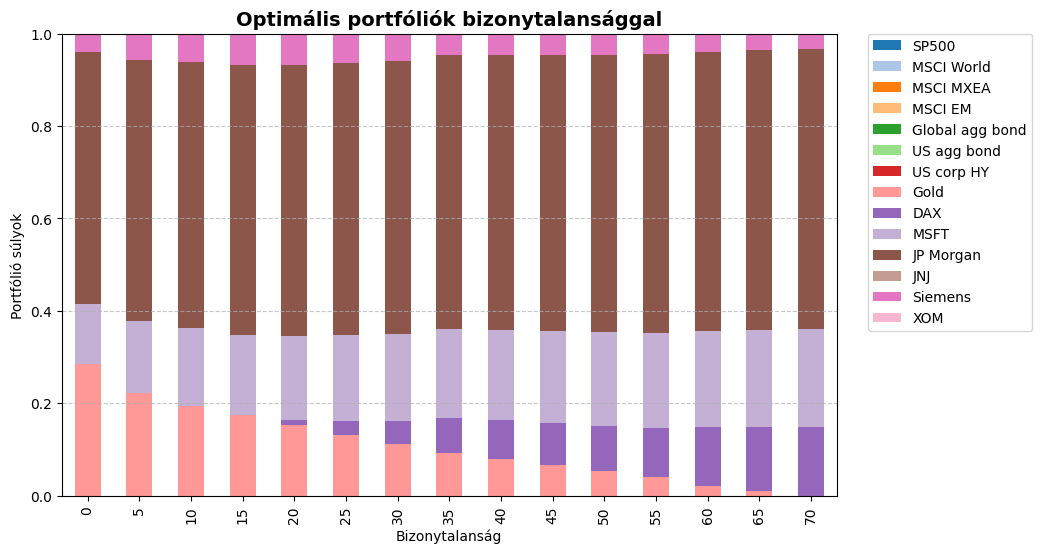

In [234]:
epsilon_values = epsilon
selected_portfolios = optimal_portfolios.loc[epsilon_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók bizonytalansággal", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Shortselling-gel 

In [235]:
epsilon = [100*x for x in range(8)]
gamma = 5  #ide mas gamma is mehetne 
optimal_portfolios = pd.DataFrame(index=epsilon, columns = list(mean_returns.index) + ['return', 'std'])

for e in epsilon:
    eps = np.array([10]*num_assets)
    eps[7] =  e
    initial_guess = np.array([1 / num_assets] * num_assets)
    result = minimize(lambda w: utility_function_uncertainity_1(w, gamma, eps), initial_guess, 
                      method='SLSQP', bounds=bounds_short_allowed, 
                      constraints=constraints_weight())
    optimal_portfolios.loc[e] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]


optimal_portfolios

,SP500,MSCI World,MSCI MXEA,MSCI EM,Global agg bond,US agg bond,US corp HY,Gold,DAX,MSFT,JP Morgan,JNJ,Siemens,XOM,return,std
0,1.00,0.30,-0.96,-0.45,-1.00,-0.16,1.00,1.00,1.00,-0.13,0.96,-0.90,-0.05,-0.62,0.85,0.37
100,1.00,0.30,-0.96,-0.45,-1.00,-0.17,1.00,1.00,1.00,-0.13,0.96,-0.90,-0.05,-0.62,0.85,0.37
200,1.00,0.31,-0.96,-0.45,-1.00,-0.17,1.00,1.00,1.00,-0.13,0.96,-0.90,-0.05,-0.62,0.85,0.37
300,1.00,0.32,-0.96,-0.43,-1.00,-0.06,1.00,0.87,1.00,-0.13,0.96,-0.91,-0.05,-0.60,0.83,0.36
400,1.00,0.33,-0.95,-0.40,-1.00,0.09,1.00,0.67,1.00,-0.13,0.94,-0.91,-0.05,-0.59,0.80,0.35
500,1.00,0.33,-0.95,-0.38,-1.00,0.23,1.00,0.50,1.00,-0.12,0.93,-0.91,-0.05,-0.58,0.77,0.35
600,1.00,0.33,-0.95,-0.35,-1.00,0.35,1.00,0.34,1.00,-0.11,0.93,-0.92,-0.05,-0.56,0.75,0.35
700,1.00,0.34,-0.95,-0.33,-1.00,0.46,1.00,0.20,1.00,-0.11,0.92,-0.92,-0.05,-0.55,0.72,0.35


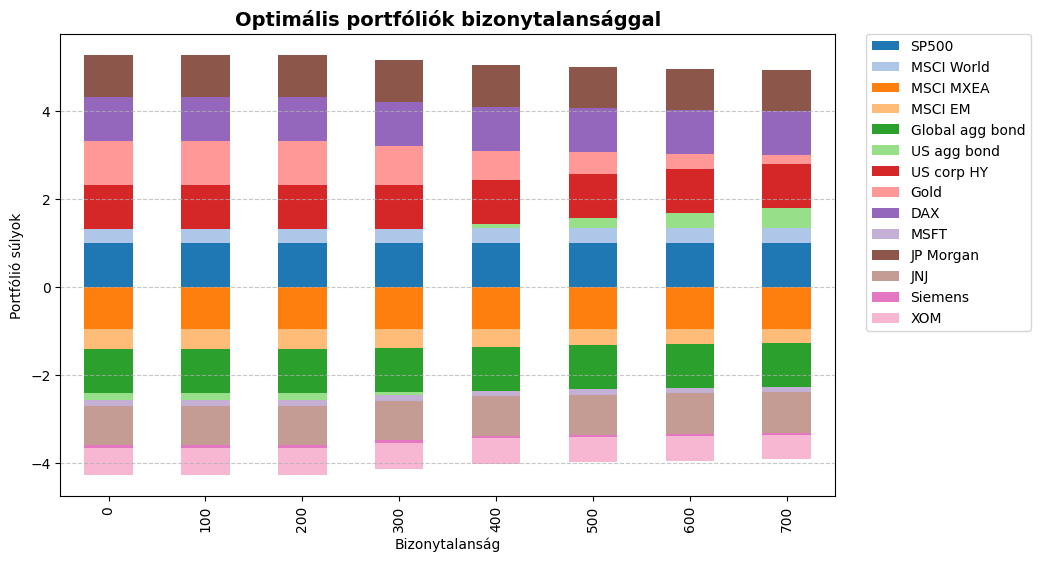

In [236]:
epsilon_values = epsilon
selected_portfolios = optimal_portfolios.loc[epsilon_values, mean_returns.index]

selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

plt.xlabel("Bizonytalanság")
plt.ylabel("Portfólió súlyok")
plt.title("Optimális portfóliók bizonytalansággal", fontsize = 14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Határportfólió görbe

### Shortselling-gel

In [237]:
max_return = minimize(portfolio_return_neg, initial_guess, method='SLSQP', bounds=bounds_short_allowed, constraints=constraints_weight())
min_return = minimize(portfolio_return, initial_guess, method='SlSQP', bounds = bounds_short_allowed, constraints=constraints_weight())
min_variance = minimize(portfolio_variance, initial_guess, method='SLSQP', bounds=bounds_short_allowed, constraints=constraints_weight())

print(f"Max portfólió súlyai: {', '.join(f'{w:.3f}' for w in max_return.x)}")
print(f"Max portfólió hozama: {f'{portfolio_return(max_return.x):3f}'}")
print(f"Max portfólió szórása: {f'{np.sqrt(portfolio_variance(max_return.x)):3f}'}")
maxvar = np.sqrt(portfolio_variance(max_return.x))
print("---------------------------------------------------")

print(f"Min portfólió súlyai: {', '.join(f'{w:.3f}' for w in min_return.x)}")
print(f"Min portfólió hozama: {f'{portfolio_return(min_return.x):3f}'}")
print(f"Min portfólió szórása: {f'{np.sqrt(portfolio_variance(min_return.x)):3f}'}")

print("---------------------------------------------------")


print(f"Min var portfólió súlyai: {', '.join(f'{w:.3f}' for w in min_variance.x)}")
print(f"Min var portfólió hozama: {f'{portfolio_return(min_variance.x):3f}'}")
print(f"Min var portfólió szórása: {f'{np.sqrt(portfolio_variance(min_variance.x)):3f}'}")
minvar = np.sqrt(portfolio_variance(min_variance.x))

asset_summarum['Max hozamú short-tal'] = max_return.x
asset_summarum['Min varianciájú short-tal'] = min_variance.x


Max portfólió súlyai: 1.000, 1.000, -1.000, -1.000, -1.000, -1.000, -0.000, 1.000, 1.000, 1.000, 1.000, -1.000, 1.000, -1.000
Max portfólió hozama: 1.321625
Max portfólió szórása: 0.718081
---------------------------------------------------
Min portfólió súlyai: -1.000, -0.000, 1.000, 1.000, 1.000, 1.000, 1.000, -1.000, -1.000, -1.000, -1.000, 1.000, -1.000, 1.000
Min portfólió hozama: -1.127664
Min portfólió szórása: 0.633679
---------------------------------------------------
Min var portfólió súlyai: -0.022, -0.103, -0.093, 0.040, 0.111, -0.014, 1.000, 0.034, -0.034, 0.020, 0.021, 0.023, 0.003, 0.014
Min var portfólió hozama: 0.043964
Min var portfólió szórása: 0.033908


In [238]:
min_var_risk = np.sqrt(portfolio_variance(min_variance.x))
min_var_return = portfolio_return(min_variance.x)

max_ret_risk = np.sqrt(portfolio_variance(max_return.x))
max_ret_return = portfolio_return(max_return.x)


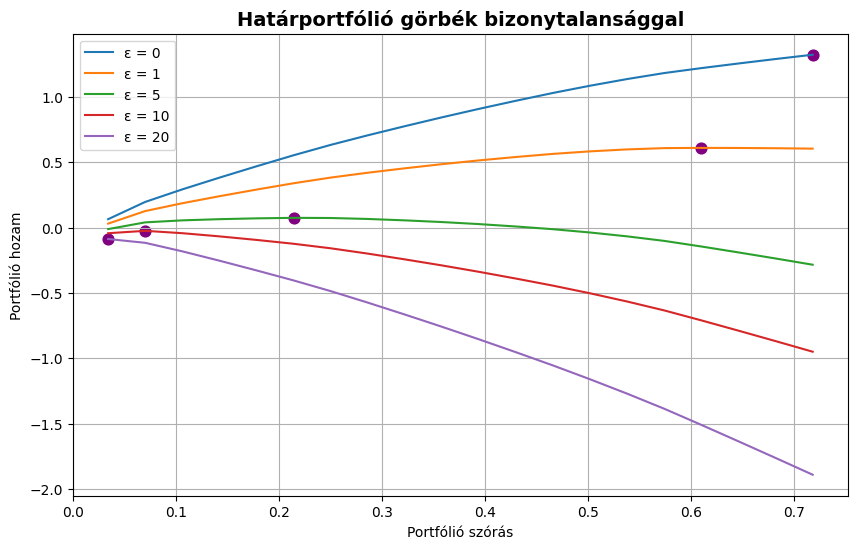

In [239]:
def constraints_uncer(target_risk):
    return [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.sqrt(portfolio_variance(weights)) - target_risk}
    ]

def adjusted_mu_for_ef(weights, epsilon):
    return -np.dot(weights, mean_returns) + np.sqrt(epsilon * portfolio_variance(weights))

target_risks = np.linspace(min_var_risk, max_ret_risk, 20)
epsilon_values = [0, 1, 5, 10, 20] 
bounds_short_allowed = [(-1, 1)] * num_assets  

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    max_return = []
    
    for target_risk in target_risks:
        initial_guess = np.array([1 / num_assets] * num_assets)
        result = minimize(lambda w: adjusted_mu_for_ef(w, epsilon), initial_guess, method='SLSQP', bounds=bounds_short_allowed, constraints=constraints_uncer(target_risk))
        max_return.append([-adjusted_mu_for_ef(result.x,epsilon),target_risk])


    sorted_list = sorted(max_return, key=lambda x: x[0], reverse=True)   
    max_return_res = [x[0] for x in max_return]   
    plt.plot(target_risks, max_return_res, label=f'ε = {epsilon}')
    plt.scatter(sorted_list[0][1], sorted_list[0][0], color='purple', marker='o', s=60)


plt.xlabel('Portfólió szórás')
plt.ylabel('Portfólió hozam')
plt.title('Határportfólió görbék bizonytalansággal', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


In [240]:
max_return_wout_s = minimize(portfolio_return_neg, initial_guess, method='SLSQP', bounds=bounds_without_shortselling, constraints=constraints_weight())
min_return_wout_s = minimize(portfolio_return, initial_guess, method='SlSQP', bounds = bounds_without_shortselling, constraints=constraints_weight())
min_variance_wout_s = minimize(portfolio_variance, initial_guess, method='SLSQP', bounds=bounds_without_shortselling, constraints=constraints_weight())

min_var_risk = np.sqrt(portfolio_variance(min_variance_wout_s.x))
min_var_return = portfolio_return(min_variance_wout_s.x)

max_ret_risk = np.sqrt(portfolio_variance(max_return_wout_s.x))
max_ret_return = portfolio_return(max_return_wout_s.x)

### Shortselling nélkül

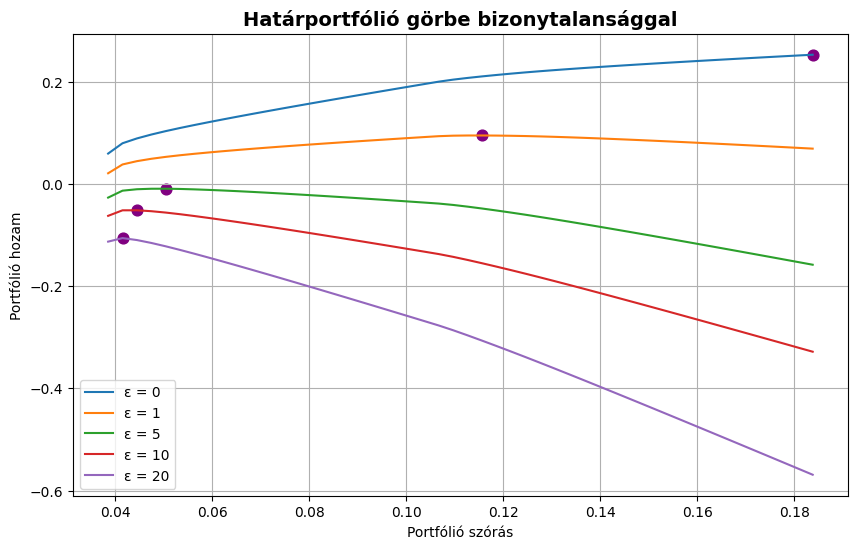

In [ ]:
target_risks = np.linspace(min_var_risk, 0.18381803728423646, 50)
epsilon_values = [0, 1, 5, 10, 20] 

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    max_return = []
    
    for target_risk in target_risks:
        initial_guess = np.array([1 / num_assets] * num_assets)
        result = minimize(lambda w: adjusted_mu_for_ef(w, epsilon), initial_guess, method='SLSQP', bounds=bounds_without_shortselling, constraints=constraints_uncer(target_risk))
        max_return.append([-adjusted_mu_for_ef(result.x,epsilon),target_risk])


    sorted_list = sorted(max_return, key=lambda x: x[0], reverse=True)   
    max_return_res = [x[0] for x in max_return]   
    plt.plot(target_risks, max_return_res, label=f'ε = {epsilon}')
    plt.scatter(sorted_list[0][1], sorted_list[0][0], color='purple', marker='o', s=60)


plt.xlabel('Portfólió szórás')
plt.ylabel('Portfólió hozam')
plt.title('Határportfólió görbék bizonytalansággal', fontsize = 14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


# Robusztussági vizsgálat 

In [242]:
original_mean = mean_returns 

In [447]:
mean_returns = original_mean

In [448]:
#np.random.seed(42)
mean_returns_list = []
for i in range(1000):
    noise = np.random.normal(loc=0, scale=0.02, size=num_assets)
    mean_returns_list.append(mean_returns+noise)

In [449]:
# 8 perc...
epsilon = [0,10,100,200,300,400,500]
gamma = 5
optimal_portfolios_dict = {}

for eps in epsilon:
    optimal_portfolios = pd.DataFrame(columns = list(mean_returns.index) + ['return', 'std'])
    for i in range(len(mean_returns_list)):
        mean_returns = mean_returns_list[i]
        initial_guess = np.array([1 / num_assets] * num_assets)
        result = minimize(lambda w: utility_function_uncertainity_2(w, gamma, eps), 
                        initial_guess, 
                        method='SLSQP',
                        bounds=bounds_without_shortselling, 
                        constraints=constraints_weight())
        optimal_portfolios.loc[i] = list(result.x) + [portfolio_return(result.x), np.sqrt(portfolio_variance(result.x))]
    optimal_portfolios_dict[eps] = optimal_portfolios

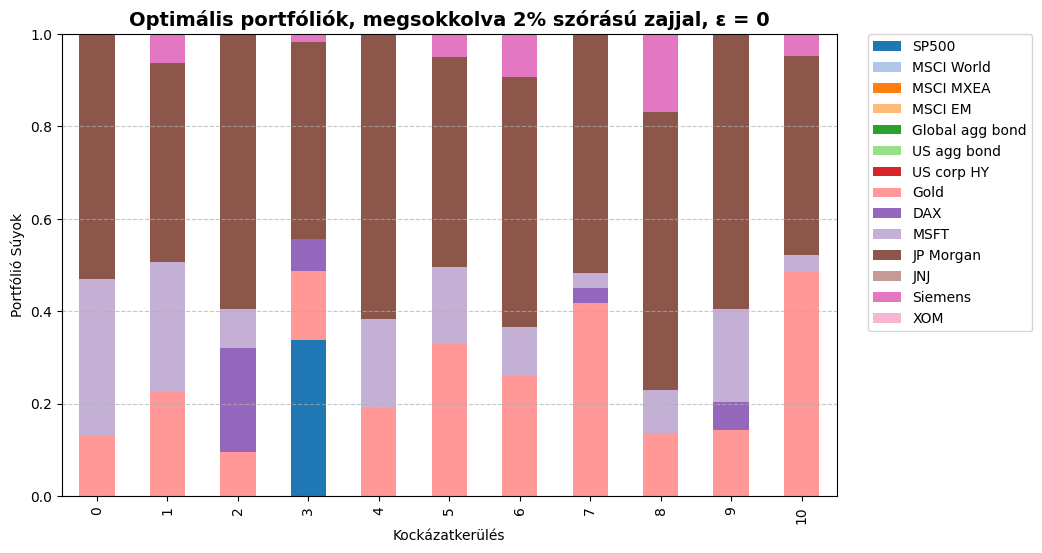

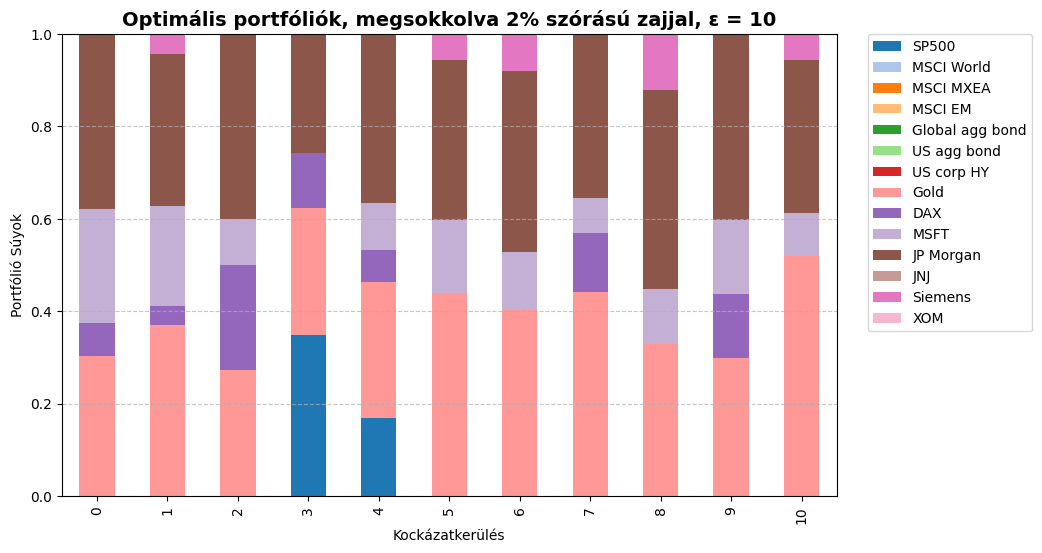

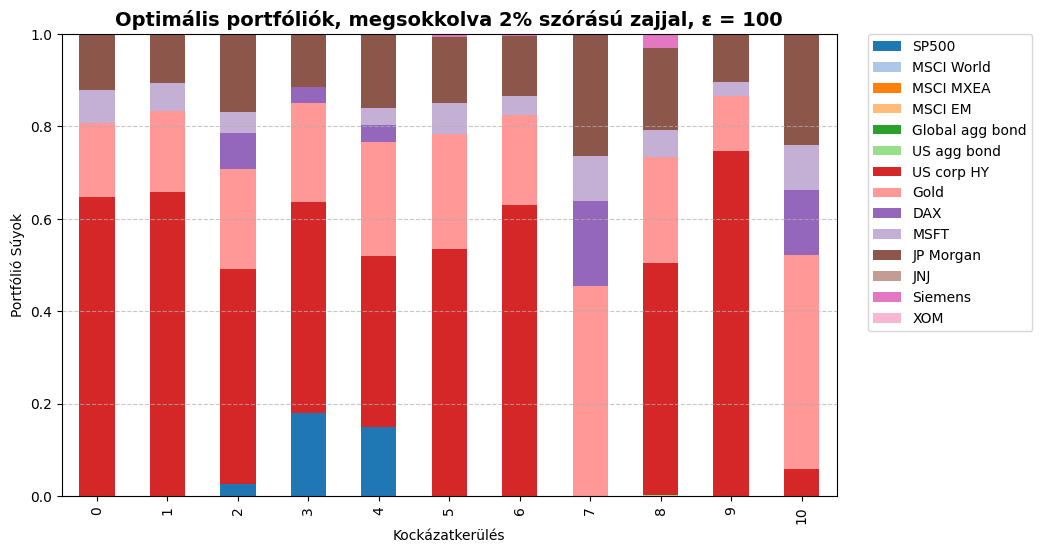

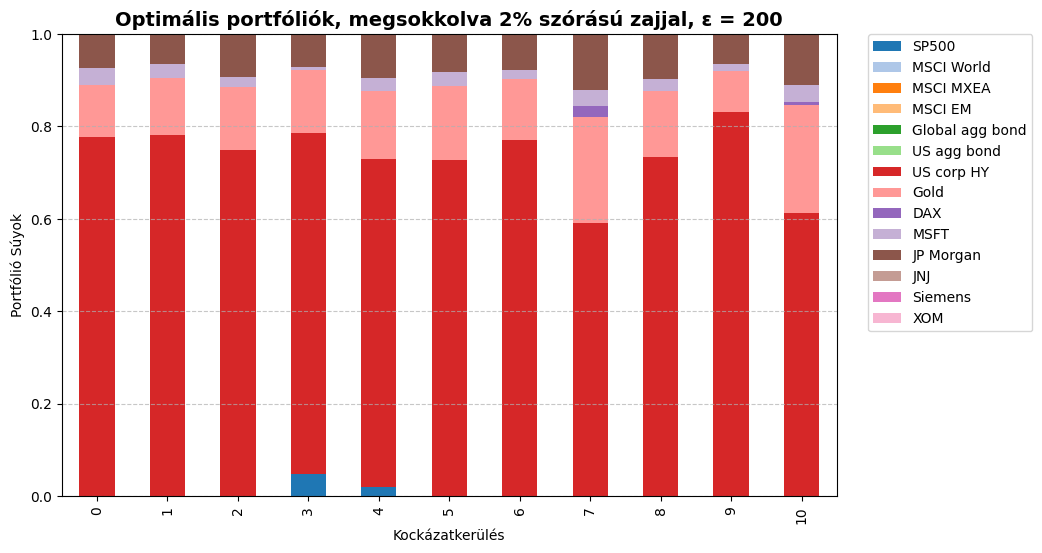

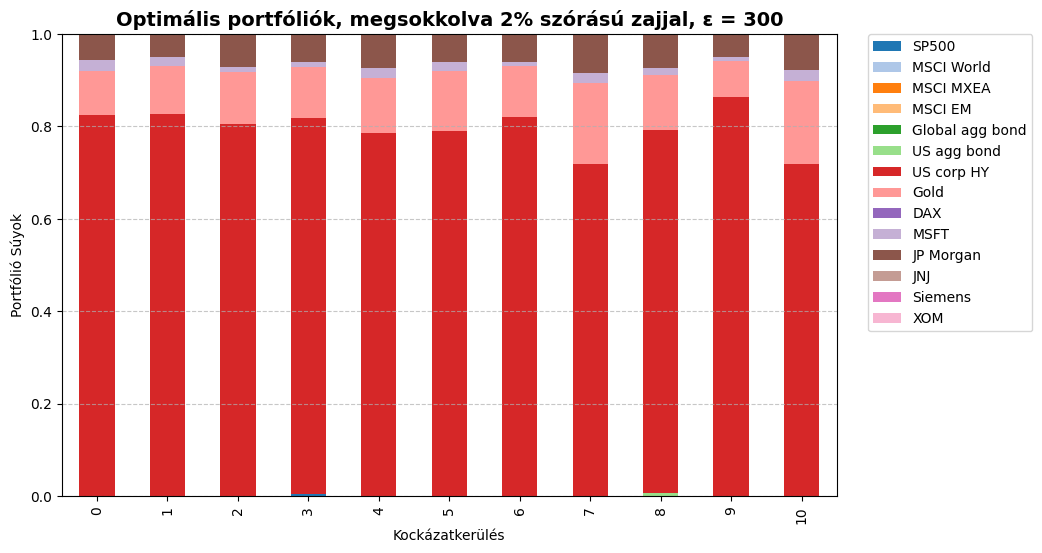

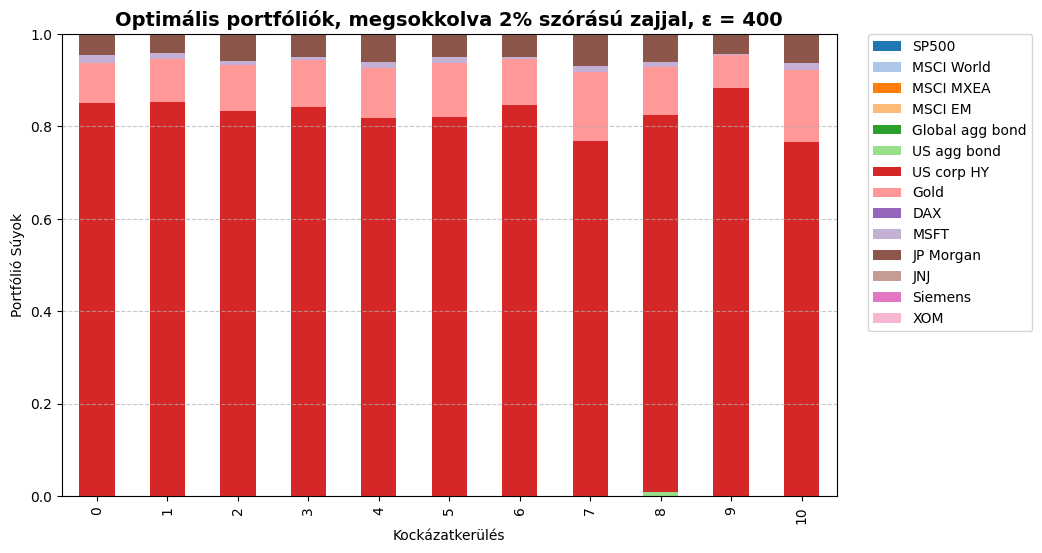

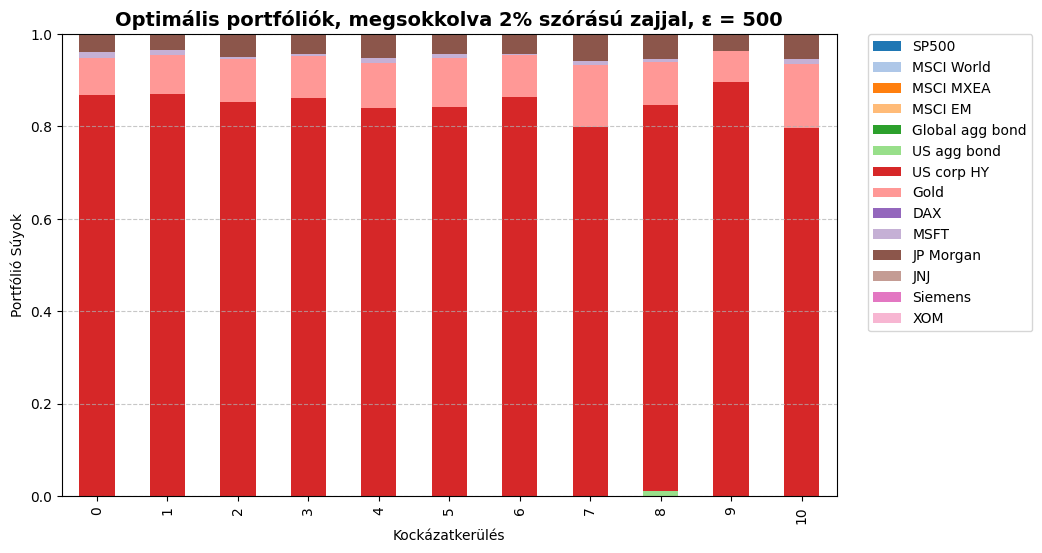

In [450]:
for eps in epsilon:
    selected_portfolios = optimal_portfolios_dict[eps].loc[:10, mean_returns.index]
    selected_portfolios.plot(kind="bar", figsize=(10, 6), stacked=True, color = colors)

    plt.xlabel("Kockázatkerülés")
    plt.ylabel("Portfólió Súyok")
    plt.title(f'Optimális portfóliók, megsokkolva 2% szórású zajjal, ε = {eps}', fontsize = 14, fontweight="bold" )
    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [451]:
robustness_values = []
for eps in epsilon:
    robustness_values.append(optimal_portfolios_dict[eps][mean_returns.index].std().mean())

robustness_values

[np.float64(0.03884555714390646),
 np.float64(0.03604812206821956),
 np.float64(0.0386033817070675),
 np.float64(0.016449018008448456),
 np.float64(0.009739133694746356),
 np.float64(0.007410376131449799),
 np.float64(0.006238340772307782)]